<a href="https://colab.research.google.com/github/MohitDhungana/duplicate_question_detection/blob/master/81-6_percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import itertools
import datetime


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/train.csv')
stops = set(stopwords.words('english'))

def text_to_word_list(text):
#   gets a whole question inside text variable on which  preprocessing is done and then the question is splitted into word indices and returned
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [0]:
vocabulary = dict() 
inverse_vocabulary = ['<unk>']

In [5]:
# Prepare embedding

  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions(i.e. 'question 1', 'question2') of the training sets provided 
# get the data from dataset(df) in  variable dataset
for dataset in [df]:
#   now iterate through the rows of the dataset using  index as iterator (i.e. goes through the row having particular index at a time) 
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions within the current  row
        for question in questions_cols:
            que2no = []  # que2no ->  numbers representation of the cureently being processed question
            
            count_ = 0

            for word in text_to_word_list(row[question]):

                # Check for unwanted words i.e mainly stopwords
                if word in stops and word not in word2vec.vocab:
                    continue
                    
#                 limit the length to 50, this decreased the time to train an epoch from more than 1 hour to 20 minutes.
                if count_ >= 50 :
                  continue
                count_ +=1
                
                
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    que2no.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    que2no.append(vocabulary[word])
#                     que2no.append(float(vocabulary[word]))

#                 que2no=list(map(int,que2no))

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, que2no)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [8]:
# max_sequence_length=50
max_seq_length = max(df.question1.map(lambda x: len(x)).max(),
                     df.question2.map(lambda x: len(x)).max()
                    )
# max_seq_length
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,"[26, 184, 3632, 115, 307, 8, 3, 24585, 522, 52...","[26, 184, 3632, 115, 307, 8, 12032, 522, 523, ...",0
404286,404286,18840,155606,"[97, 99, 2441, 307, 2, 598, 180, 1822]","[2, 47, 467, 77, 307, 2, 598, 180, 1822]",1
404287,404287,537928,537929,"[1, 2, 57, 11012]","[1, 2, 83, 11012]",0
404288,404288,537930,537931,"[1, 2, 3, 21205, 12587, 534, 2769, 33, 3114, 8...","[16, 42, 1086, 2877, 2854, 2622, 1220, 16, 173...",0
404289,404289,537932,537933,"[1, 2, 139, 401, 2543, 175, 7227]","[1, 2, 47, 139, 401, 2543, 175, 135, 7227]",0


In [0]:
embedding_dim = 300
# creating an embedding matrix whose length is one more than vocabulary and dimension is 300
embedding_matrix = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embedding_matrix[0] = 0  # So that the zeroth place remain empty 

# (Build the embedding matrix) Assigning the word2vec embedding for each words of our vocabulary  
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embedding_matrix[index] = word2vec.word_vec(word)

In [0]:
del word2vec


In [10]:
from sklearn.model_selection import train_test_split


X=df[questions_cols]
Y=df['is_duplicate']


x_train,x_validate,y_train,y_validate = train_test_split(X, Y, test_size = 0.3) # dataset split to 70% for training and 30% for validation

print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)
                 
# Split to dicts
x_train = {'left': x_train.question1, 'right': x_train.question2}
x_validate = {'left': x_validate.question1, 'right': x_validate.question2}

# Convert labels to their numpy representations
y_train=y_train.values
y_validate=y_validate.values



(283003, 2)
(121287, 2)
(283003,)
(121287,)


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# zero padding

for dataset, side in itertools.product([x_train,x_validate],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

In [12]:
# print(df['question1'][0])

# print(dataset)
print(x_train['left'].shape)
# print(x_train['left'])
print(x_validate['left'].shape)

(283003, 50)
(121287, 50)


In [0]:
# check to see if shape of left and right input is same
assert x_train['left'].shape == x_train['right'].shape

# check to see if shape of input and output is same
assert len(x_train['left']) == len(y_train)

In [14]:
# shape of question1 column (x,y)==(total rows, total words in each question)
x_train['left'].shape

(283003, 50)

In [0]:
# manhattan distance calculation function
import tensorflow.keras.backend as K
def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right),axis=1, keepdims=True))

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda, CuDNNLSTM

n_hidden = 15
n_epochs=500
gradient_clipping_norm  = 1.25

# input layer
#recheck shape before training
left_input = Input(shape = (max_seq_length,), dtype='int32',name = 'left_input')
right_input = Input(shape = (max_seq_length,), dtype='int32', name = 'right_input')



# embedding layer
# recheck dims 
embedding_layer = Embedding(input_dim = len(embedding_matrix), output_dim = embedding_dim, input_length = max_seq_length, weights=[embedding_matrix], trainable=False, name = 'embedding_layer')

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)



#LSTM instantiation
# check parameter for LSTM.
# LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)
shared_lstm = CuDNNLSTM(n_hidden, name = 'LSTM_layer')

# shared LSTM
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)




# TODO: check output shape of the output lambda layer
# output layer
output_layer = Lambda(function = lambda x : manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0],1))([left_output, right_output])



# define above model
model = tf.keras.Model(inputs=[left_input, right_input], outputs=output_layer)

# summary of model
print(model.summary())

W0629 04:17:40.747349 140099933190016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 04:17:43.723053 140099933190016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 50, 300)      25796400    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
LSTM_layer (CuDNNLSTM)          (None, 15)           19020       embedding_layer[0][0]        

In [17]:

# compile the model
from time import time
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


weight_path='/content/drive/My Drive/dqd_model_weights_80percent.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

optimizer = Adadelta(lr=1, clipnorm = gradient_clipping_norm)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

# LOG_DIR="/root/logs"
# tensorboard = TensorBoard(log_dir=LOG_DIR.format(time()))

# Start training
training_start_time = time()


# train (fit) the model
hist = model.fit([x_train['left'], x_train['right']], y_train, 
                 batch_size=64,
                 epochs=n_epochs, 
                 validation_split=0.2, 
                 callbacks=callbacks)
print(hist.history)

Train on 226402 samples, validate on 56601 samples


Using TensorFlow backend.
W0629 04:17:44.311482 140099933190016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
226048/226402 [============================>.] - ETA: 0s - loss: 0.1733 - acc: 0.7428
Epoch 00001: val_loss improved from inf to 0.16146, saving model to /content/drive/My Drive/dqd_model_weights_80percent.h5
226402/226402 [==============================] - 35s 154us/sample - loss: 0.1733 - acc: 0.7429 - val_loss: 0.1615 - val_acc: 0.7659
Epoch 2/500
225984/226402 [============================>.] - ETA: 0s - loss: 0.1564 - acc: 0.7747
Epoch 00002: val_loss improved from 0.16146 to 0.15553, saving model to /content/drive/My Drive/dqd_model_weights_80percent.h5
226402/226402 [==============================] - 33s 146us/sample - loss: 0.1564 - acc: 0.7747 - val_loss: 0.1555 - val_acc: 0.7746
Epoch 3/500
226048/226402 [============================>.] - ETA: 0s - loss: 0.1501 - acc: 0.7861
Epoch 00003: val_loss improved from 0.15553 to 0.15043, saving model to /content/drive/My Drive/dqd_model_weights_80percent.h5
226402/226402 [==============================] - 33s 145us/sample

Training time finished.
2 epochs in 0:30:37.740247


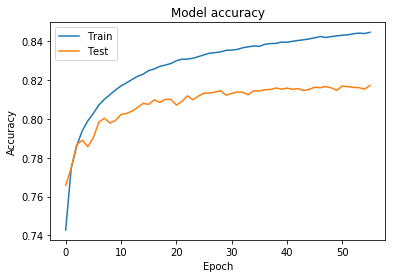

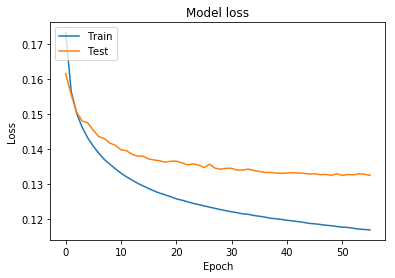

In [18]:
print("Training time finished.\n{} epochs in {}".format(2, datetime.timedelta(seconds=time()-training_start_time)))

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("abc76.png")
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("bc76.png")
plt.show()

In [0]:
!pip install pydrive

In [0]:



model.save('/content/drive/My Drive/DQD.h5')


In [21]:
model.load_weights('/content/drive/My Drive/DQD.h5')
score, acc = model.evaluate([x_validate['left'], x_validate['right']], y_validate, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

121287/121287 [==============================] - 8s 66us/sample - loss: 0.1326 - acc: 0.8164
Test score: 0.13261363475199492
Test accuracy: 0.81639415
